In [1]:
# importar bibliotecas
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import seaborn as sns

In [2]:
# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

In [3]:
# Gerar DataFrames
df_yll = client.list_rows(client.get_table('ml-na-saude.yll_por_obito.yll')).to_dataframe()
df_populacao = client.list_rows(client.get_table('ml-na-saude.yll_por_obito.populacao')).to_dataframe()
df_municipio = client.list_rows(client.get_table('ml-na-saude.yll_por_obito.municipio')).to_dataframe()

In [4]:
df_yll.head()

,ano_obito,quadrimestre_obto,dt_obito,dt_nasc,idade,yll,cid10,cd_mun_res
0,2010,1,2010-04-05,2009-10-04,0.50,89.55,J154,120035
1,2010,2,2010-07-08,2005-06-25,5.03,82.58,E41,120020
2,2010,1,2010-01-11,1989-08-04,20.44,67.62,A169,270030
3,2010,1,2010-01-30,1980-10-26,29.26,62.66,A169,270240
4,2010,2,2010-06-27,2010-03-28,0.25,89.55,E126,270642


In [5]:
df_populacao.head()

,cd_municipio,ano,populacao,porte
0,130260,2010,1802525,Metrópole
1,150140,2010,1392031,Metrópole
2,211130,2010,1011943,Metrópole
3,230440,2010,2447409,Metrópole
4,261160,2010,1536934,Metrópole


In [6]:
df_municipio.head()

,cd_regiao,nm_regiao,cd_uf,sl_uf,cd_municipio,nm_municipio
0,0,None,0,EX,0,None
1,1,Norte,11,RO,110010,Guajará-Mirim
2,1,Norte,11,RO,110037,Alto Alegre dos Parecis
3,1,Norte,11,RO,110020,Porto Velho
4,1,Norte,11,RO,110045,Buritis


In [7]:
consulta_sql = """
select
  taxa.ano_obito||'_'||taxa.quadrimestre_obto as quadrimestre_obto,
  avg(taxa.yll) as taxa_yll
from (
  select
    m.nm_municipio,
    y.ano_obito,
    y.quadrimestre_obto,
    ROUND((SUM(y.yll) / AVG(p.populacao)) * 1000, 2) AS yll
  from `ml-na-saude.yll_por_obito.yll` y
  join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
  join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
  where p.porte = 'Médio Porte'
  group by
    m.nm_municipio,
    y.ano_obito,
    y.quadrimestre_obto
) taxa
group by
  taxa.ano_obito,
  taxa.quadrimestre_obto
order by
  taxa.ano_obito,
  taxa.quadrimestre_obto
"""

In [8]:
df = client.query(consulta_sql).to_dataframe()

In [9]:
df.head()

,quadrimestre_obto,taxa_yll
0,2010_1,6.446966
1,2010_2,6.788292
2,2010_3,6.128916
3,2011_1,6.570745
4,2011_2,6.899068


In [10]:
df.shape

(30, 2)

In [11]:
# Verificar se existem dados nulos
df.isna().sum()

quadrimestre_obto    0
taxa_yll             0
dtype: int64

In [12]:
df.describe()

,taxa_yll
count,30.000000
mean,6.359448
std,0.470325
min,5.601657
25%,5.986051
50%,6.311395
75%,6.774853
max,7.261009


<Axes: xlabel='taxa_yll', ylabel='Count'>

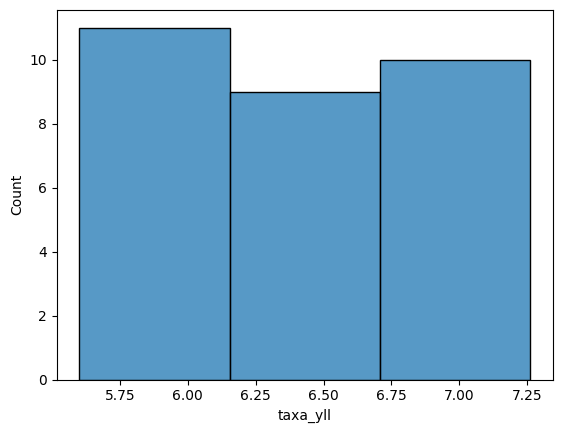

In [13]:
sns.histplot(df,x="taxa_yll",binwidth=0.5)

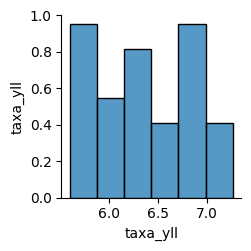

In [14]:
sns.pairplot(df)

In [15]:
# sns.pairplot(df,hue="yll")

In [ ]:
sns.boxplot(x="yll", y="cd_mun_res", data=df)

In [ ]:
sns.boxplot(x="yll", y="ano_obito", data=df)

In [ ]:
sns.heatmap(df.corr(),annot=True)

In [ ]:
df.corr()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print(df.columns)

In [ ]:
df.head()

In [ ]:
print("dimension of yll data: {}".format(df.shape))

In [ ]:
print(df.groupby('yll').size())

In [ ]:
import seaborn as sns
sns.countplot(df['yll'],label="Count")

In [ ]:
df.info()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'yll'], df['yll'], stratify=df['yll'], random_state=66)
from sklearn.neighbors import KNeighborsClassifier
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)
for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train, y_train))
    # record test set accuracy
    test_accuracy.append(knn.score(X_test, y_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

In [ ]:
tree = DecisionTreeClassifier(max_depth=3, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

In [ ]:
print("Feature importances:\n{}".format(tree.feature_importances_))

In [ ]:
def plot_feature_importances_diabetes(model):
    plt.figure(figsize=(8,6))
    n_features = 8
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), diabetes_features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
plot_feature_importances_diabetes(tree)

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
mlp = MLPClassifier(random_state=0)
mlp.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

In [ ]:
mlp = MLPClassifier(max_iter=1000, alpha=1, random_state=0)
mlp.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(8), diabetes_features)
plt.xlabel("Columns in weight matrix")
plt.ylabel("Input feature")
plt.colorbar()